# Detecção de Outliers

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import scale
from math import sqrt
from outliers import smirnov_grubbs as grubbs

## Carregar a Base de dados - Titanic

In [4]:
df = pd.read_csv("../datasets/titanic/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Sumário Estatístico

- Estatísticas básicas das colunas de Idade e Valor do Tíquete (Fare)
- Podemos notar possíveis outliers em Idade e Fare
    - 75% dos passageiros possuem idade menor que 38 anos com uma mperia de 29.7 anos. 
    - 75% dos passageiros pagaram o ticket no valor de 31, mas teve pessoas que pagaram 512 e outras que não pagaram. 

In [5]:
df[['Age', 'Fare']].describe()

,Age,Fare
count,714.000000,891.000000
mean,29.699118,32.204208
std,14.526497,49.693429
min,0.420000,0.000000
25%,20.125000,7.910400
50%,28.000000,14.454200
75%,38.000000,31.000000
max,80.000000,512.329200


# Historgrama

- Pelo Histograma podemos notar que muitos passageiros (mais de 500) não pagaram passagens
- Podemos notar que poucos pagaram passagem entre 300 e 500, mas alguns pagaram passagens por mais de 500. 
- Enquanto a idade parece serguir a distribuição normal e a idade de 80 (valor máximo) para ser um valor aceitável.

In [20]:
sqrt(df.shape[0])

29.8496231131986

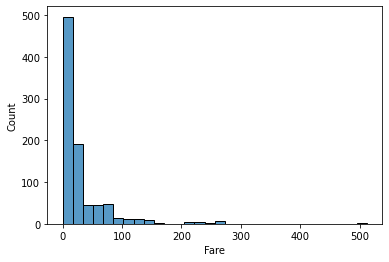

<AxesSubplot:xlabel='Age', ylabel='Count'>

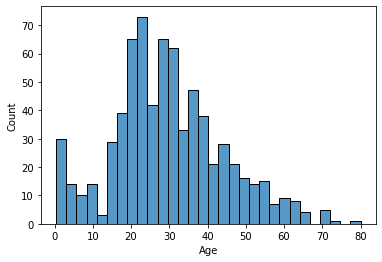

In [27]:
sns.histplot(df['Fare'], bins = round(sqrt(df.shape[0])))
plt.show()
sns.histplot(df['Age'], bins = round(sqrt(df.shape[0])))

# Box-Plot

- Fare - O boxplot nos mostra que há muitos pontos fora da curvas no preço das passagens
- Idade - Há poucos pontos fora da curva

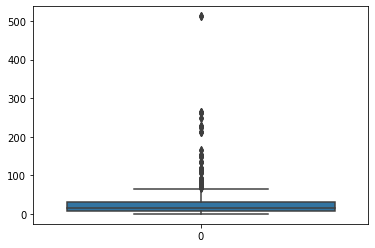

<AxesSubplot:>

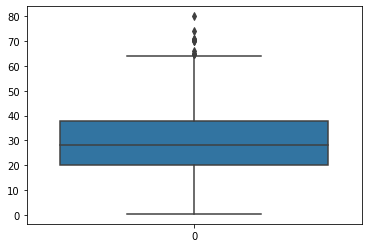

In [31]:
sns.boxplot(data = df.Fare)
plt.show()
sns.boxplot(data = df.Age)

# Gráfico de Dispersão

<AxesSubplot:xlabel='Age', ylabel='Fare'>

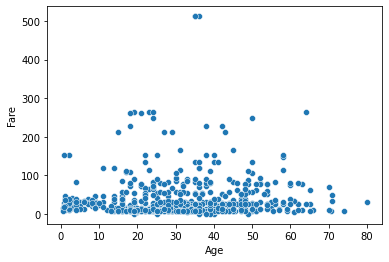

In [35]:
sns.scatterplot(x = 'Age', y = 'Fare', data = df)

# Percentis

- Fare 
    - Notamos que menos de 2% das pessoas pagaram 6.75
    - Notamos que quase 98% dos passageiros paragram passagens igual ou menor que 153
- Age
    - Notamos que 2% dos passageiros possuem idade igual ou menor que 2
    - Notamos que quase 98% dos passageiros possuem idade igual ou menor a 62

In [41]:
baixo = df.Fare.quantile(0.025)
meio = df.Fare.quantile(0.5)
alto = df.Fare.quantile(0.975)
print(baixo, meio, alto)

6.75 14.4542 153.4625


In [42]:
baixo2 = df.Age.quantile(0.025)
meio2 = df.Age.quantile(0.5)
alto2 = df.Age.quantile(0.975)
print(baixo2, meio2, alto2)

2.0 28.0 62.0


## Filtrar

- Podemos filtar com os valores obtidos

In [43]:
df[(df["Age"] < baixo2) | (df["Age"] > alto2)].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
33,34,0,2,"Wheadon, Mr. Edward H",male,66.00,0,0,C.A. 24579,10.5000,NaN,S
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.00,0,1,113509,61.9792,B30,C
78,79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,NaN,S
96,97,0,1,"Goldschmidt, Mr. George B",male,71.00,0,0,PC 17754,34.6542,A5,C
116,117,0,3,"Connors, Mr. Patrick",male,70.50,0,0,370369,7.7500,NaN,Q


In [45]:
df[(df["Fare"] < baixo) | (df["Fare"] > alto)].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0000,C23 C25 C27,S
118,119,0,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,B58 B60,C
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0000,NaN,S
202,203,0,3,"Johanson, Mr. Jakob Alfred",male,34.0,0,0,3101264,6.4958,NaN,S


# Filtro de Hampel

In [48]:
baixo = df.Fare.median() - (3 * df.Fare.std())
alto = df.Fare.median() + (3 * df.Fare.std())
print(baixo, alto)

-134.62608579154272 163.5344857915427


##  Filtrar

- Podemos filtar com os valores obtidos

In [49]:
df[(df["Fare"] < baixo) | (df["Fare"] > alto)].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0000,C23 C25 C27,S
118,119,0,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,B58 B60,C
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
299,300,1,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50.0,0,1,PC 17558,247.5208,B58 B60,C


## Teste de Grubbs

- O testde de Grubbs pode ser feito com o método grubbs.test espefificando o **nível de significancia** através do atriburo **alpha*
- O método **teste** retorna o vetor sem o valor do outlier
- O método **min_teste** e **max_teste** retorna o vetor sem o valor minino ou máximo respectivamente
- O método **min_teste_outlier** e **max_teste_outlier** retorna o valor mínimo e máximo respectivamente do outlier
- O método **min_teste_indice** e **max_teste_indice** retorna o indíce do valor mínimo e máximo respectivamente do outlier

In [93]:
newdata = grubbs.max_test(df['Fare'], alpha= 0.95)
indices = grubbs.max_test_indices(df['Fare'], alpha= 0.95)
valores = grubbs.max_test_outliers(df['Fare'], alpha= 0.95)
print(newdata, indices, valores)

0       7.2500
1      71.2833
2       7.9250
3      53.1000
4       8.0500
        ...   
886    13.0000
887    30.0000
888    23.4500
889    30.0000
890     7.7500
Name: Fare, Length: 890, dtype: float64 [258] [512.3292]


# DBScan

- Os grupos com valore zerado indica outliers, que não pertence a nenhum grupo. 

In [86]:
df['Age'].fillna(df['Age'].mean(), inplace = True)
df2 = df.copy()
df2[['Age', 'Fare']] = pd.DataFrame(scale(df[['Age', 'Fare']]),
                                    index = df.index,
                                    columns = ['Age', 'Fare'])
df2 = df2.dropna()

agrupador = DBSCAN(eps=0.9, min_samples=5)
agrupador = agrupador.fit(df2[['Age', 'Fare']])

In [87]:
previsao = agrupador.labels_
previsao

array([ 0,  0,  0,  1,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  2,  0,
        0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        1,  0,  1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, -1,  0, -1,  0, -1,  0,  0,  0,  2,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  2,  0,  0,  0,  0,  0,
        0,  2,  0,  0,  0,  0,  0,  0,  0,  0, -1,  1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  2,
        0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  2,  0,  0,  2, -1,  0,  0,
        2,  0,  0,  1,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int64)

<AxesSubplot:xlabel='Age', ylabel='Fare'>

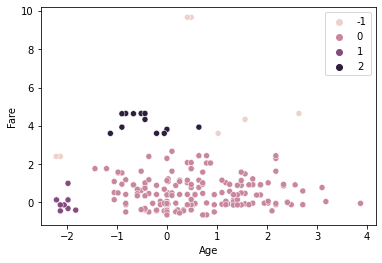

In [88]:
sns.scatterplot(x = 'Age', y = 'Fare', hue = previsao, data = df2)